# Polmann Benchmark: 1‑D Richards’ Equation (All FD Schemes)

**Richards’ equation** can be written in two equivalent forms:

1. **Mixed (θ‑based) form**  
  $$\frac{\partial \theta}{\partial t}
     \;-\;\frac{\partial}{\partial z}\bigl[K(\psi)\,\frac{\partial \psi}{\partial z}\bigr]
     \;-\;\frac{\partial K(\psi)}{\partial z}
     = 0
  $$  
   - $\theta(\psi)$: volumetric water content [–]  
   - $\psi$: pressure head [cm]  
   - K($\psi$): hydraulic conductivity [cm/s]  

2. **Pressure‑head (ψ‑based) form**  
   $$C(\psi)\,\frac{\partial \psi}{\partial t}
     \;-\;\frac{\partial}{\partial z}\bigl[K(\psi)\,\frac{\partial \psi}{\partial z}\bigr]
     \;-\;\frac{\partial K(\psi)}{\partial z}
     = 0
  $$  
   - C($\psi$)=$\frac{d\theta}{d\psi}$: specific moisture capacity [1/cm]  

---

This notebook implements **six finite‐difference schemes** under the **Polmann** benchmark (Celia et al. 1990):

- **Explicit mixed (mixed‑form)**  
- **Implicit non‑iterative (ψ‑form)**  
- **Implicit + Picard (ψ‑form)**  
- **Implicit + Picard (mixed‑form)**  
- **Implicit + Newton (ψ‑form)**  
- **Implicit + Newton (mixed‑form)**  

**Benchmark setup**:  
- Column depth = 100 cm, Δz = 2.5 cm (40 nodes)  
- Simulation time = 21 600 s (6 h), test Δt = [1 800, 900, 300, 1] s  
- Initial head ψ₀ = –1000 cm  
- Top BC: ψ = –75 cm; Bottom BC: ψ = –1000 cm  
- VG parameters: θᵣ=0.102, θₛ=0.368, α=0.0335 (1/cm), n=2, m=1–1/n=0.5, Ks=0.00922 cm/s, Ss=1e–6 (1/cm)

# INPUT SECTION

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# ——— INPUT DATA ———
def setpars():
    """
    Define van Genuchten–Mualem soil hydraulic parameters:
      thetaR: residual water content [-]
      thetaS: saturated water content [-]
      alpha : inverse air-entry suction [1/cm]
      m, n  : shape parameters (m = 1 - 1/n)
      Ks    : saturated hydraulic conductivity [cm/s]
      Ss    : specific storage [1/cm] (for mixed-form mass balance)
    Returns:
      pars: dict of parameters
    """
    pars = {}
    pars['thetaR'] = 0.102    # θr: water content when almost dry
    pars['thetaS'] = 0.368    # θs: water content at full saturation
    pars['alpha']  = 0.0335   # α: controls suction–water content curve
    pars['m']      = 0.5      # m: van Genuchten exponent (1 - 1/n)
    pars['n']      = 2.0      # n: van Genuchten exponent
    pars['Ks']     = 0.00922  # Ks: max hydraulic conductivity
    pars['Ss']     = 1e-6     # Ss: specific storage (only in mixed-form)
    return pars

# ——— SETUP FUNCTION FOR ψ‑FORM METHODS ———
def setup(dt):
    """
    Prepare spatial & temporal grids and initialize pressure head ψ array.
    Inputs:
      dt: time step [s]
    Returns:
      z    : array of depths [cm]
      t    : time vector [s]
      dz   : spatial increment [cm]
      n    : number of depth nodes
      nt   : number of time steps
      zN   : total column depth [cm]
      psi  : preallocated ψ array shape (nt, n)
      psiB : bottom boundary head [cm]
      psiT : top boundary head [cm]
      pars : soil parameters dict
    """
    pars = setpars()

    # Spatial grid
    zN = 100          # total depth of column [cm]
    dz = 2.5          # spacing between nodes [cm]
    z  = np.arange(dz, zN, dz)  # nodes at 2.5, 5.0, ..., 97.5 cm
    n  = len(z)       # number of spatial nodes

    # Temporal grid
    tN = 21600        # total simulation time [s] (6 hours)
    t  = np.arange(0, tN + dt, dt)  # time levels from 0 to tN
    nt = len(t)       # number of time steps

    # Initialize pressure head array ψ(t, z)
    psi = np.zeros((nt, n))
    psi[0, :] = -1000  # initial head (all nodes) [cm]

    # Boundary conditions (Dirichlet)
    psiB = -1000  # bottom fixed head [cm]
    psiT = -75    # top fixed head [cm]

    return z, t, dz, n, nt, zN, psi, psiB, psiT, pars

# ——— SETUP FUNCTION FOR MIXED‑FORM & NEWTON ———
def setup_mixed(dt):
    """
    Similar to setup(), but also initializes θ array for mixed-form methods.
    Returns same as setup(), plus:
      theta: preallocated θ array shape (nt, n)
    """
    pars = setpars()

    # Spatial & temporal grids identical to setup()
    zN = 100
    dz = 2.5
    z  = np.arange(dz, zN, dz)
    n  = len(z)
    tN = 21600
    t  = np.arange(0, tN + dt, dt)
    nt = len(t)

    # Initialize arrays
    psi   = np.zeros((nt, n))
    psi[0, :] = -1000  # same initial head

    theta = np.zeros((nt, n))
    theta[0, :] = thetafun(psi[0, :], pars)  # compute initial water content

    # Same boundary conditions
    psiB = -1000
    psiT = -75

    return z, t, dz, n, nt, zN, psi, psiB, psiT, pars, theta

# ——— INPUTS FOR EXPLICIT SCHEME ———
nz = 40            # number of nodes for explicit scheme
dz = 2.5           # spatial step [cm]

# Van Genuchten moisture parameters (for explicit mixed-form)
wet   = 0.200366   # moisture at ponded top [-]
dry   = 0.109937   # initial (dry) moisture [-]
avg   = 0          # conductivity averaging flag (0=arithmetic, 1=geometric)
thr   = 0.102      # θr: residual moisture [-]
ths   = 0.368      # θs: saturated moisture [-]
alpha = 0.0335     # inverse air-entry suction [1/cm]
rksat = 0.00922    # saturated conductivity Ks [cm/s]
rm    = 0.5        # m parameter (1 - 1/n)
rn    = 2.0        # N PARAMTER

# MODEL SET UP

In [ ]:
# DEPENDENT VARIABLES CALCULATION
def Cfun(psi,pars):
    x3=1+(pars['alpha']*np.abs(psi))**pars['n']
    x2=x3**(pars['m']+1)
    x1=pars['alpha']*pars['n']*pars['m']*((pars['alpha']*np.abs(psi))**(pars['n']-1))/x2
    C = np.where(psi >= 0, pars['Ss'], (pars['thetaS']-pars['thetaR'])*x1)
    return C

def Kfun(psi,pars):
    x6=1+(pars['alpha']*np.abs(psi))**pars['n']
    x5=x6**(pars['m']*0.5)
    x4=((pars['alpha']*np.abs(psi))**(pars['n']-1))*(x6**(-pars['m']))
    x3=1-x4
    x2=x3**2
    x1=x2/x5
    K = np.where(psi >= 0, pars['Ks'], pars['Ks']*x1)
    return K

def thetafun(psi,pars):
    x3=1+(pars['alpha']*np.abs(psi))**pars['n']
    x2=x3**pars['m']
    x1=(pars['thetaS']-pars['thetaR'])/x2
    theta = np.where(psi >= 0, pars['thetaS'], pars['thetaR']+x1)
    return theta

def solverfun(R,C,Kmid,dt,dz,n):
    # Initialize arrays
    a=np.zeros(n)
    b=np.zeros(n)
    c=np.zeros(n)
    y=np.zeros(n)

    # Construct matrix
    a=-Kmid[:-1]*dt/C/dz**2
    b=1.+(Kmid[:-1]+Kmid[1:])*dt/C/dz**2
    c=-Kmid[1:]*dt/C/dz**2
    A=np.diag(a[1:],-1)+np.diag(b,0)+np.diag(c[:-1],1)

    # Construct RHS
    y[:]=R[:]*dt/C

    # Boundary conditions - nothing to do
    #y[0]=y[0]
    #y[-1]=y[-1]

    # Solve:
    dell = np.linalg.solve(A, y)

    return dell

def solverfun2(R,C,Kmid,dt,dz,n):
    # Initialize arrays
    a=np.zeros(n)
    b=np.zeros(n)
    c=np.zeros(n)
    y=np.zeros(n)

    # Construct matrix
    a=Kmid[:-1]/dz
    b=-(Kmid[:-1]+Kmid[1:])/dz-C*dz/dt
    c=Kmid[1:]/dz
    A=np.diag(a[1:],-1)+np.diag(b,0)+np.diag(c[:-1],1)

    # Construct RHS
    y[:]=R[:]

    # Solve:
    dell = np.linalg.solve(A, y)

    return dell

def solverfun3(psi,C,Kmid,dt,dz,n,psiT,psiB):
    # Initialize arrays
    a=np.zeros(n)
    b=np.zeros(n)
    c=np.zeros(n)
    y=np.zeros(n)

    # Construct matrix
    a=-Kmid[:-1]*dt/C/dz**2
    b=1.+(Kmid[:-1]+Kmid[1:])*dt/C/dz**2
    c=-Kmid[1:]*dt/C/dz**2
    A=np.diag(a[1:],-1)+np.diag(b,0)+np.diag(c[:-1],1)

    # Construct RHS
    y[:]=psi+(Kmid[1:]-Kmid[:-1])*dt/C/dz

    # Boundary conditions
    y[0]=y[0]+psiB*Kmid[0]*dt/C[0]/dz**2
    y[-1]=y[-1]+psiT*Kmid[-1]*dt/C[-1]/dz**2

    # Solve:
    psinext = np.linalg.solve(A, y)

    return psinext

def Rfun(psiiter,psiin,psiT,psiB,C,Kmid,dt,dz,n):
    # This solves the Picard residual term:
    psigrid=np.hstack([psiB,psiiter,psiT])
    x1=-C*(psiiter-psiin)/dt
    x2=1/dz**2*(Kmid[1:]*(psigrid[2:]-psigrid[1:-1])-Kmid[:-1]*(psigrid[1:-1]-psigrid[:-2]))
    x3=(Kmid[1:]-Kmid[:-1])/dz
    R=x1+x2+x3

    return R

def Rfun2(psiiter,psiin,psiT,psiB,C,Kmid,dtheta,dt,dz,n):
    # This solves the Picard residual term:
    psigrid=np.hstack((psiB,psiiter,psiT))

    x1=dtheta/dt*dz
    x2=-(Kmid[1:]-Kmid[:-1])
    x3=-Kmid[1:]*(psigrid[2:]-psigrid[1:-1])/dz
    x4=Kmid[:-1]*(psigrid[1:-1]-psigrid[:-2])/dz

    R=x1+x2+x3+x4

    return R

def Rfun_mixed(psiiter, psiin, psiT, psiB, C, Kmid, dt, dz, n, theta, thetan):
    # Calculate change in theta
    delta_theta = thetafun(psiiter, pars) - thetan

    # Compute the residual using the mixed form
    psigrid = np.hstack([psiB, psiiter, psiT])
    x1 = -delta_theta / dt
    x2 = 1/dz**2 * (Kmid[1:] * (psigrid[2:] - psigrid[1:-1]) - Kmid[:-1] * (psigrid[1:-1] - psigrid[:-2]))
    x3 = (Kmid[1:] - Kmid[:-1]) / dz
    R = x1 + x2 + x3

    return R

def Jacobian(psiiter, psiin, psiT, psiB, C, Kmid, dt, dz, n, R):
    n_nodes = len(psiiter)

    # Initialize Jacobian matrix
    J = np.zeros((n_nodes, n_nodes))

    for i in range(n_nodes):
        # Perturb psiiter[i] by a small amount
        d_psi = 1e-6
        psiiter_perturbed = psiiter.copy()
        psiiter_perturbed[i] += d_psi

        # Compute perturbed residual
        R_perturbed = Rfun(psiiter_perturbed, psiin, psiT, psiB, C, Kmid, dt, dz, n)

        # Compute column i of the Jacobian matrix
        J[:, i] = (R_perturbed - R) / d_psi

    return J

def Jacobian_mixed(psiiter, psiin, psiT, psiB, C, Kmid, dt, dz, n, R, theta, thetan):
    n_nodes = len(psiiter)
    J = np.zeros((n_nodes, n_nodes))

    for i in range(n_nodes):
        d_psi = 1e-6
        psiiter_perturbed = psiiter.copy()
        psiiter_perturbed[i] += d_psi
        theta_perturbed = thetafun(psiiter_perturbed, pars)
        delta_theta_perturbed = theta_perturbed - thetan

        # Compute perturbed residual with updated C and Kmid
        R_perturbed = Rfun_mixed(psiiter_perturbed, psiin, psiT, psiB, C, Kmid, dt, dz, n, theta_perturbed, thetan)

        # Compute column i of the Jacobian matrix
        J[:, i] = (R_perturbed - R) / d_psi

    return J

def iterfun_implicit(psiin,pars,psiT,psiB,dt,dz,n):
    # Here, psiin, psiiter and psiout are 1D array in z
    psiiter = psiin.copy()
    C=Cfun(psiiter,pars)
    K = Kfun(np.hstack([psiB, psiiter, psiT]),pars)
    Kmid = (K[1:] + K[:-1]) / 2
    psiout = solverfun3(psiiter,C,Kmid,dt,dz,n,psiT,psiB)

    return psiout

def iterfun_picard(psiin,pars,psiT,psiB,dt,dz,n):
    # psiin = psi^n
    # psiiter = psi^n+1,m
    # psiout = psi^n+1,m+1

    tolerance=1e-10
    maxcount=1000

    # Initialize arrays
    psiiter=np.zeros(len(psiin))
    psiout=np.zeros(len(psiin))

    # Initial guess: psi_n+1^1 = psi_n
    psiiter[:]=psiin[:]

    count=0
    while count <= maxcount:
        # Get C, K:
        C = Cfun(psiiter, pars)
        K = Kfun(np.hstack([psiB, psiiter, psiT]), pars)
        Kmid = (K[1:] + K[:-1]) / 2
        # Get R
        R = Rfun(psiiter, psiin, psiT, psiB, C, Kmid, dt, dz, n)
        # Solve for delta psi using the solver function
        dell = solverfun(R, C, Kmid, dt, dz, n)
        # Update psi estimates at different iteration levels
        psiout[:] = psiiter[:] + dell[:]

        psiiter[:] = psiout[:]

        # Check for convergence
        if np.max(np.abs(R)) < tolerance:
            break

        count += 1

    return psiout

def iterfun_newton(psiin, pars, psiT, psiB, dt, dz, n):
    # psiin = psi^n
    # psiiter = psi^n+1,m
    # psiout = psi^n+1,m+1

    tolerance = 1e-10
    maxcount = 1000

    # Initialize arrays
    psiiter = np.zeros(len(psiin))
    psiout = np.zeros(len(psiin))

    # Initial guess: psi_n+1^1 = psi_n
    psiiter[:] = psiin[:]

    count = 0
    while count < maxcount:
        # Get C, K:
        C = Cfun(psiiter, pars)
        K = Kfun(np.hstack([psiB, psiiter, psiT]), pars)
        Kmid = (K[1:] + K[:-1]) / 2

        # Get R
        R = Rfun(psiiter, psiin, psiT, psiB, C, Kmid, dt, dz, n)
        J = Jacobian(psiiter, psiin, psiT, psiB, C, Kmid, dt, dz, n, R)

        # Solve for delta psi using the Newton update formula
        delta_psi = np.linalg.solve(J, -R)

        # Update psi estimates
        psiout[:] = psiiter[:] + delta_psi[:]

        psiiter[:] = psiout[:]
        norm_delta_psi = np.linalg.norm(delta_psi)

        # Check for convergence
        if norm_delta_psi < tolerance:
            break

        count += 1

    return psiout

def iterfun_modpicard(psiin,pars,psiT,psiB,dt,dz,n):
    # psiin = psi^n
    # psiiter = psi^n+1,m
    # psiout = psi^n+1,m+1

    tolerance=1e-10
    maxcount=1000

    # Initialize arrays
    psiiter=np.zeros(len(psiin))
    psiout=np.zeros(len(psiin))

    # Initial guess: psi_n+1^1 = psi_n
    psiiter[:]=psiin[:]

    count=0
    while count <= maxcount:
        # Get C,K:
        C=Cfun(psiiter,pars)
        K=Kfun(np.hstack((psiB, psiiter, psiT)),pars)
        Kmid=(K[1:]+K[:-1])/2.
        dtheta=thetafun(psiiter,pars)-thetafun(psiin,pars)
        # Get R
        R=Rfun2(psiiter,psiin,psiT,psiB,C,Kmid,dtheta,dt,dz,n)
        # Solve for del
        dell=solverfun2(R,C,Kmid,dt,dz,n)
        # Update psi estimates at different iteration levels
        psiout[:]=psiiter[:]+dell[:]

        psiiter[:]=psiout[:]

        # Check for convergence
        if np.max(np.abs(R)) < tolerance:
            break

        count+=1

    return psiout

def iterfun_mixed(psiin, thetain, pars, psiT, psiB, dt, dz, n):
    tolerance = 1e-10
    maxcount = 1000

    # Initialize arrays
    psiiter = np.zeros(len(psiin))
    psiout = np.zeros(len(psiin))

    # Initial guess: psi_n+1^1 = psi_n
    psiiter[:] = psiin[:]

    # Get the initial theta based on the initial psi
    thetan = thetain[:]
    theta = thetafun(psiiter, pars)

    count = 0
    while count < maxcount:
        # Get C, K at the current iteration level:
        C = Cfun(psiiter, pars)
        K = Kfun(np.hstack([psiB, psiiter, psiT]), pars)
        Kmid = (K[1:] + K[:-1]) / 2

        # Get R using the mixed form of RE
        R = Rfun_mixed(psiiter, psiin, psiT, psiB, C, Kmid, dt, dz, n, theta, thetan)

        # Get the Jacobian using the mixed form of RE
        J = Jacobian_mixed(psiiter, psiin, psiT, psiB, C, Kmid, dt, dz, n, R, theta, thetan)

        # Solve for delta psi using the Newton update formula
        delta_psi = np.linalg.solve(J, -R)

        # Update psi estimates
        psiout[:] = psiiter[:] + delta_psi[:]

        # Update theta based on the new psi estimates
        theta = thetafun(psiout, pars)

        # Check for convergence using the norm of delta psi
        norm_delta_psi = np.linalg.norm(delta_psi)
        if norm_delta_psi < tolerance:
            break

        # Prepare for next iteration
        psiiter[:] = psiout[:]
        count += 1

    # Check if the iteration count was exceeded
    if count == maxcount:
        raise Exception("Maximum number of iterations exceeded")

    return psiout, theta

def massbal(psi,psiT,psiB,pars,n,dt,dz):
    # Initial storage:
    theta=thetafun(psi,pars)
    S=np.sum(theta*dz,1)
    S0=S[0]
    SN=S[-1]

    # Inflow:
    Kin=(Kfun(psiB,pars)+Kfun(psi[:,0],pars))/2
    QIN=-Kin*((psi[:,0]-psiB)/dz+1)
    QIN[0]=0
    QINsum=np.sum(QIN)*dt

    # Outflow:
    Kout=(Kfun(psi[:,-1],pars)+Kfun(psiT,pars))/2
    QOUT=-Kout*((psiT-psi[:,-1])/dz+1)
    QOUT[0]=0.
    QOUTsum=np.sum(QOUT)*dt

    # Balance:
    dS=SN-S0
    dQ=QINsum-QOUTsum
    err=dS/dQ

    return QIN,QOUT,S,err

def ModelRun_implicit(dt,dz,n,nt,psi,psiB,psiT,pars):
    # Solve:
    for j in range(1,nt):
        psi[j,:]=iterfun_implicit(psi[j-1,:],pars,psiT,psiB,dt,dz,n)

    QIN,QOUT,S,err=massbal(psi,psiT,psiB,pars,n,dt,dz)

    return psi,QIN,QOUT,S,err

def ModelRun_picard(dt,dz,n,nt,psi,psiB,psiT,pars):
    # Solve:
    for j in range(1,nt):
        psi[j,:]=iterfun_picard(psi[j-1,:],pars,psiT,psiB,dt,dz,n)

    QIN,QOUT,S,err=massbal(psi,psiT,psiB,pars,n,dt,dz)

    return psi,QIN,QOUT,S,err

def ModelRun_newton(dt,dz,n,nt,psi,psiB,psiT,pars):
    # Solve:
    for j in range(1,nt):
        psi[j,:]=iterfun_newton(psi[j-1,:],pars,psiT,psiB,dt,dz,n)

    QIN,QOUT,S,err=massbal(psi,psiT,psiB,pars,n,dt,dz)

    return psi,QIN,QOUT,S,err

def ModelRun_modpicard(dt,dz,n,nt,psi,psiB,psiT,pars):
    # Solve:
    for j in range(1,nt):
        psi[j,:]=iterfun_modpicard(psi[j-1,:],pars,psiT,psiB,dt,dz,n)

    QIN,QOUT,S,err=massbal(psi,psiT,psiB,pars,n,dt,dz)

    return psi,QIN,QOUT,S,err

def ModelRun_mixed(dt, dz, n, nt, psi, theta, psiB, psiT, pars):
    # Solve:
    for j in range(1, nt):
        # Update theta for the current time step
        thetain = theta[j-1, :]

        # Run the iteration function for the mixed form
        psi[j, :], theta[j, :] = iterfun_mixed(psi[j-1, :], thetain, pars, psiT, psiB, dt, dz, n)

    # Calculate mass balance with the mixed form
    QIN, QOUT, S, err = massbal(psi, psiT, psiB, pars, n, dt, dz)

    return psi, QIN, QOUT, S, err

# MODEL SETUP FOR EXPLICIT METHOD
def condf(th):
    if th >= ths:
        return rksat
    else:
        xx = (th - thr) / (ths - thr)
        if xx < 0:
            return 0
        return rksat * (xx**0.5) * (1 - (1 - xx**(1 / rm))**rm)**2

def headf(th):
    if th >= ths:
        return 0
    else:
        xx = (th - thr) / (ths - thr)
        if xx <= 0:
            return float('inf')  # return positive infinity for invalid values
        return -(xx**(-1 / rm) - 1)**(1 / rn) / alpha

# Explicit finite difference scheme build up
def update(dry, dt, dtdz, dz, nz, wet, water):
    darcy = np.zeros(nz)

    h_old = headf(wet) # top boundary condition
    c_old = condf(wet) # top boundary condition

    for iz in range(1, nz + 1):
        h_new = headf(water[iz - 1])
        c_new = condf(water[iz - 1])

        # Arithmetic or geometric average for Conductivity
        if avg == 0:
            cond = 0.5 * (c_old + c_new)
        else:
            cond = np.sqrt(c_old * c_new)

        # darcy(iz) corresponds to x(iz-0.5)-(iz-0.5)*dz
        darcy[iz - 1] = -cond * ((h_new - h_old) / dz - 1)
        h_old = h_new
        c_old = c_new

    # Now update the theta values
    for iz in range(1, nz):
        dwater = -dtdz * (darcy[iz] - darcy[iz - 1])
        water[iz - 1] = water[iz - 1] + dwater
        water[nz - 1] = dry # bottom boundary condition

    return water

# SIMULATION RUN

Total simulation time: 0.14136385917663574 seconds


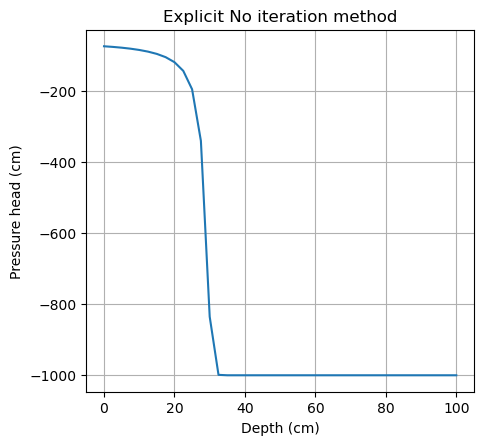

In [ ]:
# NO ITERATION METHOD (EXPLICIT SCHEME)
# Lists to store x and head values for plotting
z_values = []
head_values = []
water_values = []

# Initialize cumulative variable water (moisture content) and dtdz
dt = 40
dtdz = dt / dz
water = np.zeros(nz)  # Initialize water content array

# Set water array values (Initial condition)
for iz in range(1, nz+1):
    water[iz - 1] = dry

# Run the simulation
sim_time = 21600
start_time = time.time()  # record the start time

t = 0  # set time to 0 and it will run until the simulation time

while t < sim_time:
    t += dt

    run = update(dry, dt, dtdz, dz, nz, wet, water)

    # Append z, moisture, and head values for plotting (for the last time step)
    z_values = np.hstack([0, [iz*dz for iz in range(1, nz + 1)]])
    head_values = np.hstack([headf(wet), [headf(water[iz - 1]) for iz in range(1, nz + 1)]])
    water_values = np.hstack([wet, [water[iz - 1] for iz in range(1, nz + 1)]])

    # Break out of the loop if the next time step exceeds sim_time
    if t >= sim_time:
        break

# Calculate the total simulation time
total_sim_time = time.time() - start_time
# Print the total simulation time
print(f"Total simulation time: {total_sim_time} seconds")

plt.figure(figsize=(5, 4.7))

# Plotting pressure head for the last time step
plt.plot(z_values, head_values)
plt.ylabel('Pressure head (cm)')
plt.xlabel('Depth (cm)')
plt.title('Explicit No iteration method')
plt.grid(True)
plt.show()

Simulation time for dt = 5400 s: 0.0019919872283935547 seconds
Simulation time for dt = 3000 s: 0.0019941329956054688 seconds
Simulation time for dt = 270 s: 0.01296854019165039 seconds
Simulation time for dt = 1 s: 2.7964799404144287 seconds


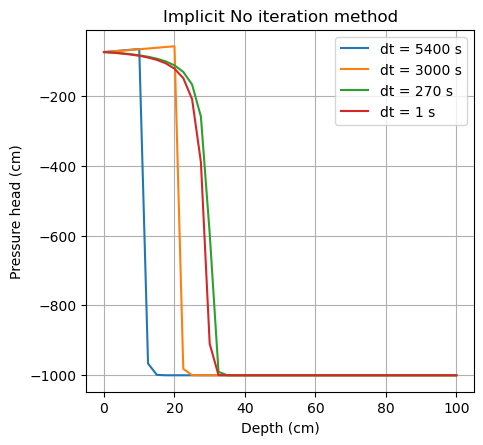

In [ ]:
# NO ITERATION METHOD (IMPLICIT SCHEME)
dt=np.array([5400, 3000, 270, 1]) # Define different dt values
err_values_implicit = []

psi_results_implicit = {} # Initialize a dictionary to store psi values for each dti

plt.figure(figsize=(5, 4.7))

for dti in dt:
    z,t,dz,n,nt,zN,psi,psiB,psiT,pars=setup(dti)

    start_time = time.time()  # Record the start time

    psi,QIN,QOUT,S,err=ModelRun_implicit(dti,dz,n,nt,psi,psiB,psiT,pars)

    # Record the end time
    end_time = time.time()

    z=np.hstack([0,z,zN])
    z=z[-1]-z
    psi_implicit=np.hstack([psiB,psi[-1,:],psiT]) # Solve for pressure head (psi)
    theta_implicit = thetafun(psi_implicit,pars) # Solve for moisture content (theta)
    K_implicit = Kfun(psi_implicit,pars) # Solve for hydraulic conductivity (K)

    psi_results_implicit[dti] = psi_implicit # Store psi values in the dictionary

    psi_plot_implicit = plt.plot(z, psi_implicit, label=f'dt = {dti} s') # Plot z vs psi for each dti

    # Calculate and print the simulation time for each dti
    sim_time = end_time - start_time
    print(f"Simulation time for dt = {dti} s: {sim_time} seconds")


    # Append the err value for the current dt to the list
    err_values_implicit.append(err)

# Convert the list of err values to a numpy array for easy plotting
err_values_implicit = np.array(err_values_implicit)

plt.xlabel('Depth (cm)')
plt.ylabel('Pressure head (cm)')
plt.title('Implicit No iteration method')
plt.legend()  # Show legend with dti values
plt.grid(True)
plt.show()

Simulation time for dt = 5400 s: 0.06981158256530762 seconds
Simulation time for dt = 3000 s: 0.08975863456726074 seconds
Simulation time for dt = 900 s: 0.09674239158630371 seconds
Simulation time for dt = 1 s: 11.387600898742676 seconds


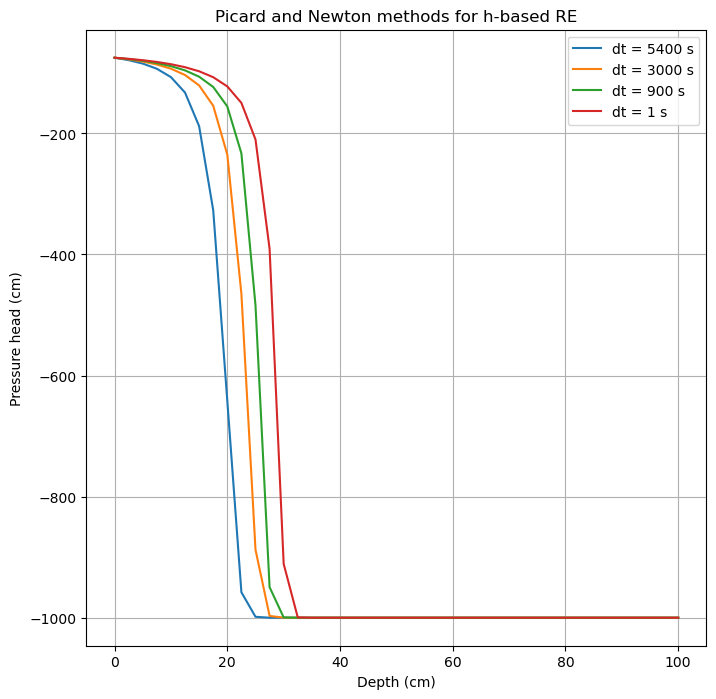

In [ ]:
# PICARD METHOD
dt=np.array([5400, 3000, 900, 1]) # Define different dt values
err_values_picard = []

psi_results_picard = {} # Initialize a dictionary to store psi values for each dti

plt.figure(figsize=(15, 8))

for dti in dt:
    z,t,dz,n,nt,zN,psi,psiB,psiT,pars=setup(dti)

    start_time = time.time()  # Record the start time

    psi,QIN,QOUT,S,err=ModelRun_picard(dti,dz,n,nt,psi,psiB,psiT,pars)

    # Record the end time
    end_time = time.time()

    z=np.hstack([0,z,zN])
    z=z[-1]-z
    psi_picard=np.hstack([psiB,psi[-1,:],psiT]) # Solve for pressure head (psi)
    theta_picard = thetafun(psi_picard,pars) # Solve for moisture content (theta)
    K_picard = Kfun(psi_picard,pars) # Solve for hydraulic conductivity (K)

    psi_results_picard[dti] = psi_picard # Store psi values in the dictionary

    psi_plot_picard = plt.plot(z, psi_picard, label=f'dt = {dti} s') # Plot z vs psi for each dti

    # Calculate and print the simulation time for each dti
    sim_time = end_time - start_time
    print(f"Simulation time for dt = {dti} s: {sim_time} seconds")


    # Append the err value for the current dt to the list
    err_values_picard.append(err)

# Convert the list of err values to a numpy array for easy plotting
err_values_picard = np.array(err_values_picard)

plt.xlabel('Depth (cm)')
plt.ylabel('Pressure head (cm)')
plt.title('Standard Picard method')
plt.legend()  # Show legend with dti values
plt.grid(True)
plt.show()

Simulation time for dt = 5400 s: 0.8519430160522461 seconds
Simulation time for dt = 3000 s: 1.0448908805847168 seconds
Simulation time for dt = 900 s: 1.457080364227295 seconds
Simulation time for dt = 1 s: 118.7168231010437 seconds


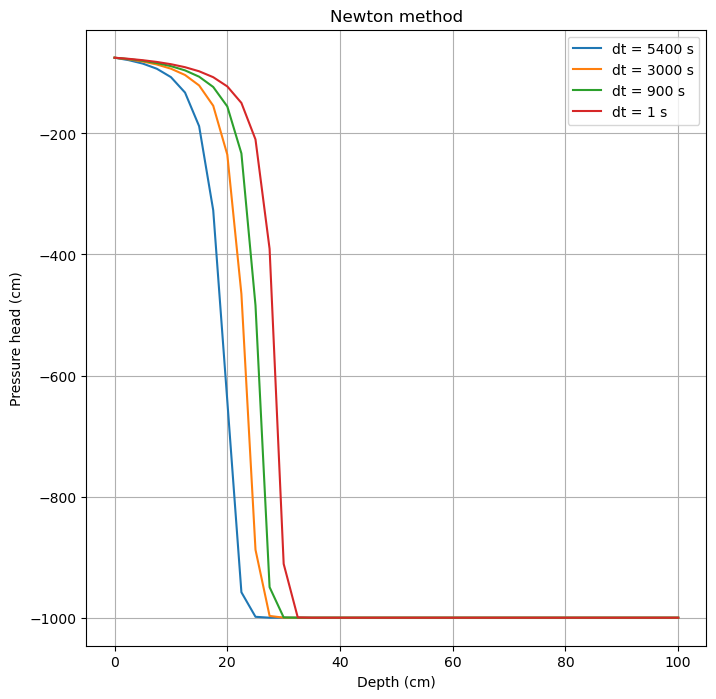

In [ ]:
# NEWTON METHOD
dt=np.array([5400, 3000, 900, 1]) # Define different dt values
err_values_newton = []

psi_results_newton = {} # Initialize a dictionary to store psi values for each dti

plt.figure(figsize=(15, 8))

for dti in dt:
    z,t,dz,n,nt,zN,psi,psiB,psiT,pars=setup(dti)

    start_time = time.time()  # Record the start time

    psi,QIN,QOUT,S,err=ModelRun_newton(dti,dz,n,nt,psi,psiB,psiT,pars)

    # Record the end time
    end_time = time.time()

    z=np.hstack([0,z,zN])
    z=z[-1]-z
    psi_newton=np.hstack([psiB,psi[-1,:],psiT]) # Solve for pressure head (psi)
    theta_newton = thetafun(psi_newton,pars) # Solve for moisture content (theta)
    K_newton = Kfun(psi_newton,pars) # Solve for hydraulic conductivity (K)

    psi_results_newton[dti] = psi_newton # Store psi values in the dictionary

    psi_plot_newton = plt.plot(z, psi_newton, label=f'dt = {dti} s') # Plot z vs psi for each dti

    # Calculate and print the simulation time for each dti
    sim_time = end_time - start_time
    print(f"Simulation time for dt = {dti} s: {sim_time} seconds")

    # Append the err value for the current dt to the list
    err_values_newton.append(err)

# Convert the list of err values to a numpy array for easy plotting
err_values_newton = np.array(err_values_newton)

plt.xlabel('Depth (cm)')
plt.ylabel('Pressure head (cm)')
plt.title('Newton method')
plt.legend()  # Show legend with dti values
plt.grid(True)
plt.show()

Simulation time for dt = 5400 s: 0.030949831008911133 seconds
Simulation time for dt = 3000 s: 0.032900094985961914 seconds
Simulation time for dt = 900 s: 0.05784440040588379 seconds
Simulation time for dt = 1 s: 12.593334197998047 seconds


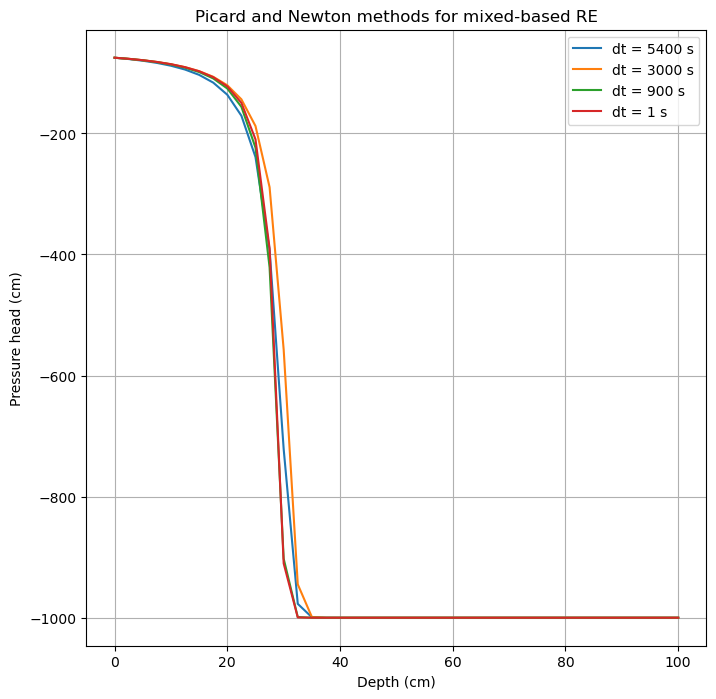

In [ ]:
# MODIFIED PICARD METHOD
dt=np.array([5400, 3000, 900, 1]) # Define different dt values
err_values_modpicard = []

psi_results_modpicard = {} # Initialize a dictionary to store psi values for each dti

plt.figure(figsize=(15, 8))

for dti in dt:
    z,t,dz,n,nt,zN,psi,psiB,psiT,pars=setup(dti)

    start_time = time.time()  # Record the start time

    psi,QIN,QOUT,S,err=ModelRun_modpicard(dti,dz,n,nt,psi,psiB,psiT,pars)

    # Record the end time
    end_time = time.time()

    z=np.hstack([0,z,zN])
    z=z[-1]-z
    psi_modpicard=np.hstack([psiB,psi[-1,:],psiT]) # Solve for pressure head (psi)
    theta_modpicard = thetafun(psi_modpicard,pars) # Solve for moisture content (theta)
    K_modpicard = Kfun(psi_modpicard,pars) # Solve for hydraulic conductivity (K)

    psi_results_modpicard[dti] = psi_modpicard # Store psi values in the dictionary

    psi_plot_modpicard = plt.plot(z, psi_modpicard, label=f'dt = {dti} s') # Plot z vs psi for each dti

    # Calculate and print the simulation time for each dti
    sim_time = end_time - start_time
    print(f"Simulation time for dt = {dti} s: {sim_time} seconds")

    # Append the err value for the current dt to the list
    err_values_modpicard.append(err)

# Convert the list of err values to a numpy array for easy plotting
err_values_modpicard = np.array(err_values_modpicard)

plt.xlabel('Depth (cm)')
plt.ylabel('Pressure head (cm)')
plt.title('Modified Picard method')
plt.legend()  # Show legend with dti values
plt.grid(True)
plt.show()

Simulation time for dt = 5400 s: 0.6346030235290527 seconds
Simulation time for dt = 3000 s: 0.965064525604248 seconds
Simulation time for dt = 900 s: 1.656747817993164 seconds
Simulation time for dt = 1 s: 225.34486937522888 seconds


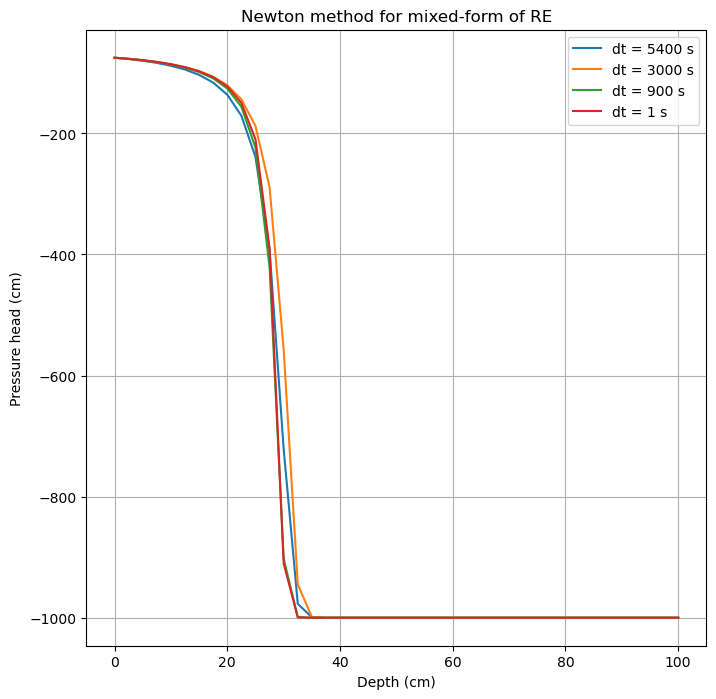

In [ ]:
# NEWTON METHOD FOR MIXED-FORM OF RICHARDS' EQUATION
dt=np.array([5400, 3000, 900, 1]) # Define different dt values
err_values_mixed = []

psi_results_mixed = {} # Initialize a dictionary to store psi values for each dti

plt.figure(figsize=(15, 8))

for dti in dt:
    z, t, dz, n, nt, zN, psi, psiB, psiT, pars, theta_initial = setup_mixed(dti)

    start_time = time.time()  # Record the start time

    psi, QIN, QOUT, S, err = ModelRun_mixed(dti, dz, n, nt, psi, theta_initial, psiB, psiT, pars)

    # Record the end time
    end_time = time.time()

    z=np.hstack([0,z,zN])
    z=z[-1]-z
    psi_mixed=np.hstack([psiB,psi[-1,:],psiT]) # Solve for pressure head (psi)
    theta_mixed = thetafun(psi_mixed,pars) # Solve for moisture content (theta)
    K_mixed = Kfun(psi_mixed,pars) # Solve for hydraulic conductivity (K)

    psi_results_mixed[dti] = psi_mixed # Store psi values in the dictionary

    psi_plot_mixed = plt.plot(z, psi_mixed, label=f'dt = {dti} s') # Plot z vs psi for each dti

    # Calculate and print the simulation time for each dti
    sim_time = end_time - start_time
    print(f"Simulation time for dt = {dti} s: {sim_time} seconds")


    # Append the err value for the current dt to the list
    err_values_mixed.append(err)

# Convert the list of err values to a numpy array for easy plotting
err_values_mixed = np.array(err_values_mixed)

plt.xlabel('Depth (cm)')
plt.ylabel('Pressure head (cm)')
plt.title('Newton method for mixed-form of RE')
plt.legend()  # Show legend with dti values
plt.grid(True)
plt.show()

# COMPARISON OF RESULTS

In [ ]:
# Convert psi_results to DataFrame
psi_implicit_df = pd.DataFrame(psi_results_implicit)
psi_picard_df = pd.DataFrame(psi_results_picard)
psi_newton_df = pd.DataFrame(psi_results_newton)
psi_modpicard_df = pd.DataFrame(psi_results_modpicard)
psi_mixed_df = pd.DataFrame(psi_results_mixed)

# Concatenate along the columns (axis=1)
psi_combined = pd.concat([psi_implicit_df, psi_picard_df, psi_newton_df, psi_modpicard_df, psi_mixed_df], axis=1)

# Add the 'z' values as the first column
psi_combined.insert(0, 'Depth (cm)', z)
psi_combined = psi_combined.iloc[::-1]

# Save DataFrame as a string and write to an Excel file
excel_file = r"Comparison_results.xlsx" # Specify the name where you want to save the Excel file
psi_combined.to_excel(excel_file, index=False) # Export the DataFrame to an Excel file

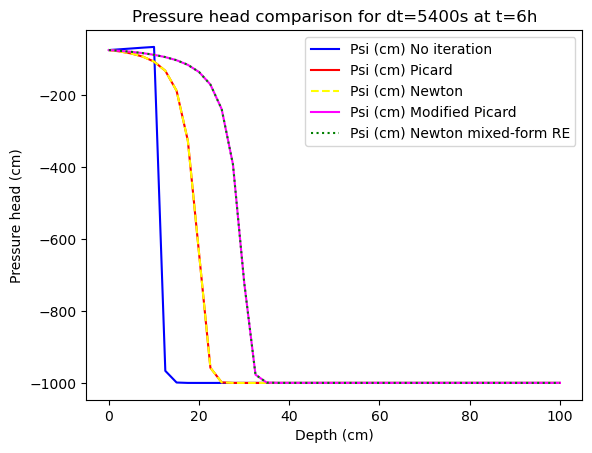

In [ ]:
# Plotting the results for chosen dt (change dt name to avoid confusion)
dt1_df = pd.concat([psi_combined.iloc[:, 0], psi_combined.iloc[:, 1], psi_combined.iloc[:, 5], psi_combined.iloc[:, 9], psi_combined.iloc[:, 13], psi_combined.iloc[:, 17]], axis=1)
dt1_df.columns = ['Depth (cm)', 'Psi (cm) No iteration', 'Psi (cm) Picard', 'Psi (cm) Newton', 'Psi (cm) Modified Picard', 'Psi (cm) Newton mixed-form RE']

# Define a dictionary for colors and line styles
styles = {
    'Psi (cm) No iteration': ('blue', '-'),
    'Psi (cm) Picard': ('red', '-'),
    'Psi (cm) Newton': ('yellow', '--'),
    'Psi (cm) Modified Picard': ('magenta', '-'),
    'Psi (cm) Newton mixed-form RE': ('green', ':')  # Custom dash pattern
}

# Plotting directly from DataFrame with custom styles
for col in dt1_df.columns[1:]:
    plt.plot(dt1_df[dt1_df.columns[0]], dt1_df[col], label=col, color=styles[col][0], linestyle=styles[col][1])

# Customize the plot as needed
plt.xlabel('Depth (cm)')
plt.ylabel('Pressure head (cm)')
plt.title('Pressure head comparison for dt=5400s at t=6h') # Change dt and t values
plt.legend()  # Show legend

# Show the plot
plt.show()

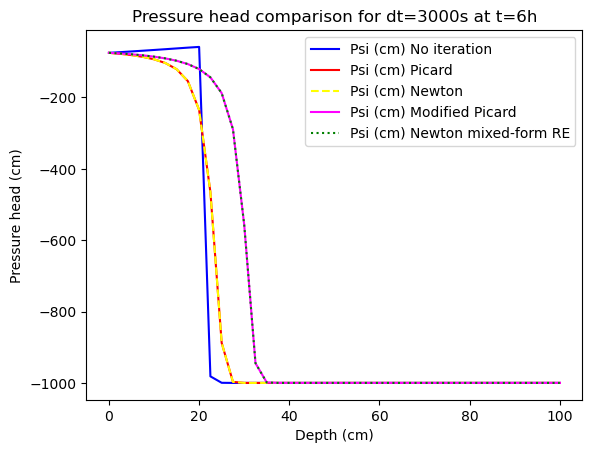

In [ ]:
# Plotting the results for chosen dt (change dt name to avoid confusion)
dt2_df = pd.concat([psi_combined.iloc[:, 0], psi_combined.iloc[:, 2], psi_combined.iloc[:, 6], psi_combined.iloc[:, 10], psi_combined.iloc[:, 14], psi_combined.iloc[:, 18]], axis=1)
dt2_df.columns = ['Depth (cm)', 'Psi (cm) No iteration', 'Psi (cm) Picard', 'Psi (cm) Newton', 'Psi (cm) Modified Picard', 'Psi (cm) Newton mixed-form RE']

# Define a dictionary for colors and line styles
styles = {
    'Psi (cm) No iteration': ('blue', '-'),
    'Psi (cm) Picard': ('red', '-'),
    'Psi (cm) Newton': ('yellow', '--'),
    'Psi (cm) Modified Picard': ('magenta', '-'),
    'Psi (cm) Newton mixed-form RE': ('green', ':')  # Custom dash pattern
}

# Plotting directly from DataFrame with custom styles
for col in dt2_df.columns[1:]:
    plt.plot(dt2_df[dt2_df.columns[0]], dt2_df[col], label=col, color=styles[col][0], linestyle=styles[col][1])

# Customize the plot as needed
plt.xlabel('Depth (cm)')
plt.ylabel('Pressure head (cm)')
plt.title('Pressure head comparison for dt=3000s at t=6h') # Change dt and t values
plt.legend()  # Show legend

# Show the plot
plt.show()

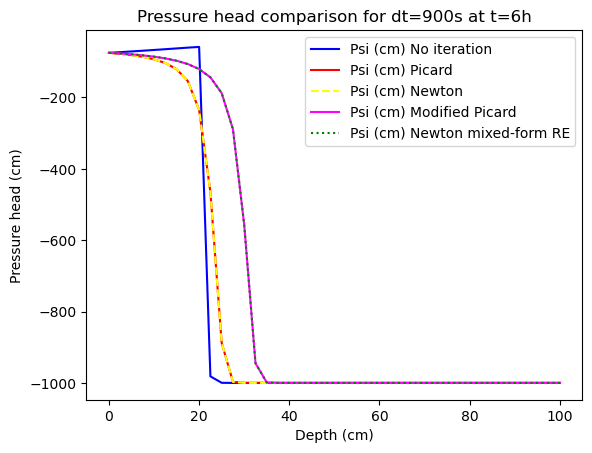

In [ ]:
# Plotting the results for chosen dt (change dt name to avoid confusion)
dt3_df = pd.concat([psi_combined.iloc[:, 0], psi_combined.iloc[:, 3], psi_combined.iloc[:, 7], psi_combined.iloc[:, 11], psi_combined.iloc[:, 15], psi_combined.iloc[:, 19]], axis=1)
dt3_df.columns = ['Depth (cm)', 'Psi (cm) Implicit No iter.', 'Psi (cm) Picard', 'Psi (cm) Newton', 'Psi (cm) Modified Picard', 'Psi (cm) Newton mixed-form RE']
dt3_df.insert(1, 'Psi (cm) Explicit No iter.', head_values)

# Define a dictionary for colors and line styles
styles = {
    'Psi (cm) No iteration': ('blue', '-'),
    'Psi (cm) Picard': ('red', '-'),
    'Psi (cm) Newton': ('yellow', '--'),
    'Psi (cm) Modified Picard': ('magenta', '-'),
    'Psi (cm) Newton mixed-form RE': ('green', ':')  # Custom dash pattern
}

# Plotting directly from DataFrame with custom styles
for col in dt2_df.columns[1:]:
    plt.plot(dt2_df[dt2_df.columns[0]], dt2_df[col], label=col, color=styles[col][0], linestyle=styles[col][1])

# Customize the plot as needed
plt.xlabel('Depth (cm)')
plt.ylabel('Pressure head (cm)')
plt.title('Pressure head comparison for dt=900s at t=6h') # Change dt and t values
plt.legend()  # Show legend

# Show the plot
plt.show()

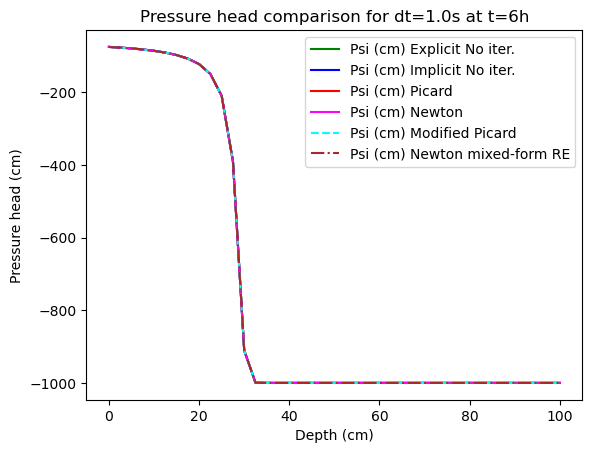

In [ ]:
# Plotting the results for chosen dt (change dt name to avoid confusion)
dt3_df = pd.concat([psi_combined.iloc[:, 0], psi_combined.iloc[:, 4], psi_combined.iloc[:, 8], psi_combined.iloc[:, 12], psi_combined.iloc[:, 16], psi_combined.iloc[:, 20]], axis=1)
dt3_df.columns = ['Depth (cm)', 'Psi (cm) Implicit No iter.', 'Psi (cm) Picard', 'Psi (cm) Newton', 'Psi (cm) Modified Picard', 'Psi (cm) Newton mixed-form RE']
dt3_df.insert(1, 'Psi (cm) Explicit No iter.', head_values)

# Define a dictionary for colors and line styles
styles = {
    'Psi (cm) Implicit No iter.': ('blue', '-'),
    'Psi (cm) Explicit No iter.': ('green', '-'),
    'Psi (cm) Picard': ('red', '-'),
    'Psi (cm) Newton': ('magenta', '-'),
    'Psi (cm) Modified Picard': ('cyan', '--'),
    'Psi (cm) Newton mixed-form RE': ('brown', '-.')  # Custom dash pattern
}

# Plotting directly from DataFrame with custom styles
for col in dt3_df.columns[1:]:
    plt.plot(dt3_df[dt3_df.columns[0]], dt3_df[col], label=col, color=styles[col][0], linestyle=styles[col][1])

# Customize the plot as needed
plt.xlabel('Depth (cm)')
plt.ylabel('Pressure head (cm)')
plt.title('Pressure head comparison for dt=1.0s at t=6h') # Change dt and t values
plt.legend()  # Show legend

# Show the plot
plt.show()

# MASS BALANCE SIMULATION

In [ ]:
print(err_values_implicit, err_values_picard, err_values_newton, err_values_modpicard, err_values_mixed)

[ 9.53093823 11.13704153 10.62224422  1.0026102 ] [0.33696839 0.45472809 0.65295385 0.99750405] [0.33696814 0.45472811 0.65295377 0.99750405] [0.99999993 0.99999998 0.99999999 1.        ] [1. 1. 1. 1.]


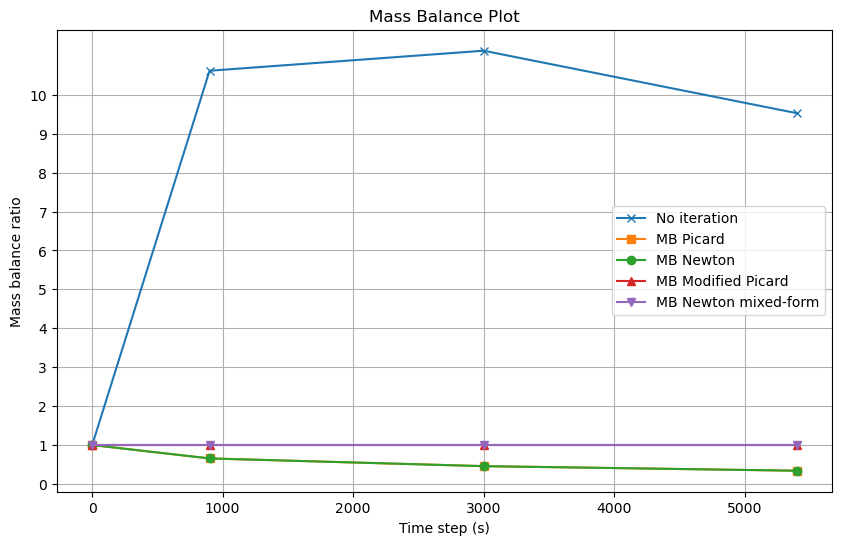

In [ ]:
# Define the reference value to check closeness
reference_value = 1.0  # Reference value to compare with
# Set a tolerance level for equality
tolerance = 1e-6  # Define the tolerance level here
# Applying the condition to modify err_values
condition0 = np.isclose(err_values_implicit, reference_value, atol=tolerance)
condition1 = np.isclose(err_values_picard, reference_value, atol=tolerance)
condition2 = np.isclose(err_values_newton, reference_value, atol=tolerance)
condition3 = np.isclose(err_values_modpicard, reference_value, atol=tolerance)
condition4 = np.isclose(err_values_mixed, reference_value, atol=tolerance)
mb_implicit = np.where(condition0, reference_value, err_values_implicit)
mb_picard = np.where(condition1, reference_value, err_values_picard)
mb_newton = np.where(condition2, reference_value, err_values_newton)
mb_modpicard = np.where(condition3, reference_value, err_values_modpicard)
mb_mixed = np.where(condition4, reference_value, err_values_mixed)

# Plotting err against dt
plt.figure(figsize=(10, 6))

plt.plot(dt, mb_implicit, marker='x', label='No iteration')
plt.plot(dt, mb_picard, marker='s', label='MB Picard')
plt.plot(dt, mb_newton, marker='o', label='MB Newton')
plt.plot(dt, mb_modpicard, marker='^', label='MB Modified Picard')
plt.plot(dt, mb_mixed, marker='v', label='MB Newton mixed-form')

plt.xlabel('Time step (s)')
plt.ylabel('Mass balance ratio')
plt.title('Mass Balance Plot')
plt.legend()
plt.grid(True)
# Set y-axis ticks explicitly
plt.yticks(range(0, 11))  # Adjust the range as needed
plt.show()